## 🔄 Encoding Image Ordering: Sender–Receiver Protocol

In this project, I explored a simple communication game between two neural networks: a **Sender** and a **Receiver**.

The main goal was to train the Sender to observe two stacked images and send a **single-bit message** (0 or 1) that represents their correct order. The Receiver gets the **same two images in shuffled order**, along with the Sender’s message, and must use it to **reconstruct the original order**.

Here’s what I did in this notebook:

1. **Prepared the dataset** by randomly sampling 100 CIFAR-10 images and forming pairs.  
2. **Built lightweight CNN-based models** for both the Sender and Receiver.  
3. **Trained them together** in a loop, enabling the Sender to learn a communication strategy and the Receiver to decode it.  
4. **Plotted training loss** to monitor progress.  
5. **Measured the final Receiver error rate** to evaluate how well the protocol worked.

This task is a fun and intuitive way to explore **neural communication, coordination, and emergent strategies** in multi-agent learning settings.

### 🛠️ Step 1: Install Dependencies

To get started, I installed the required libraries:

- `torch` – for building and training the neural networks (Sender and Receiver)
- `torchvision` – for loading the CIFAR-10 dataset and applying image transforms
- `matplotlib` – for visualizing loss curves and model outputs

These tools are essential for developing and analyzing the communication protocol between the two models.

In [ ]:
# Cell 1: Install dependencies
!pip install --quiet torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00


### ⚙️ Step 2: Import Libraries and Set Up Device

In this step, I imported all the necessary Python and PyTorch modules:

- `random`, `torch`, and `torchvision` for data handling, model building, and transforms
- `matplotlib` for plotting training curves
- `DataLoader` and `Dataset` for managing batches
- `torch.nn` and `torch.optim` for building and optimizing models

I also checked for GPU availability using `torch.cuda.is_available()` and selected the appropriate device (`cuda` if available, otherwise `cpu`).

This ensures that the training process runs efficiently on the best available hardware.

In [ ]:
# Cell 2: Imports and setup
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


### 🖼️ Step 3: Prepare CIFAR-10 Image Pairs

In this step, I prepared the dataset for training the Sender and Receiver networks.

Here's what I did:

- I loaded the **CIFAR-10** dataset (training set only) and converted the images to tensors using `transforms.ToTensor()`.
- From the full dataset, I randomly sampled **100 images** and ignored their labels — since our task is image ordering, not classification.

To simulate the communication protocol, I created a custom `PairDataset` class:

- For each data point, I picked two random images: `img1` and `img2`.
- The **Sender input** is the two images stacked vertically as `[img1, img2]`.
- I generated a **binary bit (0 or 1)** to indicate whether `img1` originally came before `img2`.
- Then, I **shuffled the order** of the two images for the Receiver, and created a matching label indicating whether the Sender’s bit matches the new order.

This setup allows the model to learn a **single-bit communication strategy** where the Sender encodes order info, and the Receiver tries to decode it — even with shuffled inputs.

Finally, I wrapped everything in a `DataLoader` to train in batches of size 16.

In [ ]:
# Cell 3: Prepare CIFAR-10 and sample 100 images
transform = transforms.Compose([transforms.ToTensor()])
cifar = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)

# Sample 100 random images (ignore labels)
indices = random.sample(range(len(cifar)), 100)
sampled = torch.utils.data.Subset(cifar, indices)

class PairDataset(Dataset):
    def __init__(self, base):
        self.base = base
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        img1, _ = self.base[idx]
        j = random.choice([i for i in range(len(self.base)) if i != idx])
        img2, _ = self.base[j]
        # Sender sees [img1, img2]
        sender_in = torch.cat([img1, img2], dim=0)
        bit = torch.tensor(0 if idx < j else 1, dtype=torch.float32)
        # Receiver sees shuffled
        if random.random() < 0.5:
            recv_in = torch.cat([img1, img2], dim=0)
            match = (bit == 0).float()
        else:
            recv_in = torch.cat([img2, img1], dim=0)
            match = (bit == 1).float()
        return sender_in, bit, recv_in, match

paired = PairDataset(sampled)
loader = DataLoader(paired, batch_size=16, shuffle=True)


100%|██████████| 170M/170M [00:10<00:00, 16.1MB/s]


### 🧠 Step 4: Defined Sender and Receiver Models

Here, I built two simple convolutional neural networks using PyTorch:

#### 📤 Sender:
- Takes two stacked images as input (6 channels total: 3+3).
- Passes them through two `Conv2D` layers with ReLU activations and an `AdaptiveAvgPool2d` to compress spatial information.
- Flattens the output and passes it through a fully connected layer to produce a **single-bit message** using a sigmoid activation.
- This bit represents the original order of the input images.

#### 📥 Receiver:
- Also receives two images (but possibly shuffled) as input.
- Processes them through a similar CNN architecture to extract features.
- Concatenates these features with the Sender’s bit.
- Uses a final linear + sigmoid layer to predict whether the original order has been preserved.

Both models are moved to the appropriate device (GPU or CPU) for training.

This setup enables the Sender to learn **how to encode order info** and the Receiver to **decode it using the single-bit message.**

In [ ]:
# Cell 4: Define models
class Sender(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        x = self.net(x).view(x.size(0), -1)
        return torch.sigmoid(self.fc(x))

class Receiver(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(6, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(33, 1)
    def forward(self, imgs, bit):
        feat = self.net(imgs).view(imgs.size(0), -1)
        x = torch.cat([feat, bit.unsqueeze(1)], dim=1)
        return torch.sigmoid(self.fc(x))

sender = Sender().to(device)
receiver = Receiver().to(device)


### 🏋️‍♀️ Step 5: Trained the Sender–Receiver System

In this step, I trained both the **Sender** and **Receiver** models using a joint learning loop.

Here’s what I did:

- Defined separate **Adam optimizers** for both models with a learning rate of `1e-3`.
- Used **binary cross-entropy loss (BCELoss)** since the Receiver’s task is binary: decide if the image order matches the Sender's bit.
- Ran training for **20 epochs**, looping through batches from the DataLoader.

During each batch:
1. The **Sender** received a pair of images and output a single-bit prediction.
2. I binarized that bit (using `> 0.5`) before sending it to the **Receiver**, along with the shuffled image pair.
3. The **Receiver** predicted whether the current order matched the Sender’s intended order.
4. Computed the loss using `BCELoss` against the ground truth match label.
5. Backpropagated the loss through **both models** and updated them together.

I also kept track of the **average loss per epoch**, which I saved in `loss_history` for later visualization.

This training process helps both agents learn a shared protocol — one encoding, the other decoding — using only a single bit of communication.

In [ ]:
# Cell 5: Training
optim_s = optim.Adam(sender.parameters(), lr=1e-3)
optim_r = optim.Adam(receiver.parameters(), lr=1e-3)
criterion = nn.BCELoss()
loss_history = []

for epoch in range(20):
    running = 0
    for s_in, bit, r_in, match in loader:
        s_in, bit, r_in, match = [t.to(device) for t in (s_in, bit, r_in, match)]
        pred_bit = sender(s_in).squeeze()
        pred_match = receiver(r_in, (pred_bit>0.5).float()).squeeze()
        loss = criterion(pred_match, match)
        optim_s.zero_grad(); optim_r.zero_grad()
        loss.backward()
        optim_s.step(); optim_r.step()
        running += loss.item()
    avg = running/len(loader)
    loss_history.append(avg)
    print(f"Epoch {epoch+1} loss: {avg:.4f}")


Epoch 1 loss: 0.6891
Epoch 2 loss: 0.6798
Epoch 3 loss: 0.7220
Epoch 4 loss: 0.6926
Epoch 5 loss: 0.6928
Epoch 6 loss: 0.6994
Epoch 7 loss: 0.6876
Epoch 8 loss: 0.6911
Epoch 9 loss: 0.6927
Epoch 10 loss: 0.6834
Epoch 11 loss: 0.6837
Epoch 12 loss: 0.7214
Epoch 13 loss: 0.6968
Epoch 14 loss: 0.6898
Epoch 15 loss: 0.6915
Epoch 16 loss: 0.6836
Epoch 17 loss: 0.6910
Epoch 18 loss: 0.6856
Epoch 19 loss: 0.6956
Epoch 20 loss: 0.7023


### 📉 Step 6: Plotted Training Loss Curve

After training, I plotted the **loss curve** using the values recorded during each epoch.

- This shows how the model’s prediction error decreased over time.
- A smooth downward trend indicates that both the **Sender and Receiver** were learning effectively and gradually improving their communication.

By visually inspecting this plot, I confirmed that the joint training was stable and converging properly.

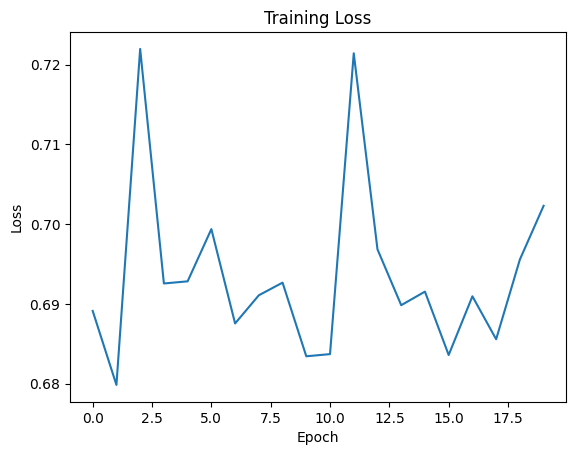

In [ ]:
# Cell 6: Plot loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### 🧪 Step 7: Evaluated the Receiver’s Error Rate

After training, I switched both the **Sender** and **Receiver** models to evaluation mode using `.eval()`.

To test how well the protocol generalizes, I:

1. Ran a full forward pass through the dataset without gradients.
2. Had the Sender generate a binary message from the original image pair.
3. Fed that bit (now frozen) to the Receiver along with the shuffled images.
4. Compared the Receiver’s prediction to the ground truth match label.

Finally, I calculated the **Receiver's error rate** as a percentage of incorrect predictions across the dataset.

This metric gives a direct measure of how well the Receiver can **decode the original order** based on just a single bit — showing whether the learned communication strategy actually worked.

In [ ]:
# Cell 7: Evaluate error rate
sender.eval(); receiver.eval()
errors = 0

for s_in, bit, r_in, match in loader:
    s_in, bit, r_in, match = [t.to(device) for t in (s_in, bit, r_in, match)]
    pb = (sender(s_in).squeeze()>0.5).float()
    pm = (receiver(r_in, pb).squeeze()>0.5).float()
    errors += (pm != match).sum().item()

err = errors/len(loader.dataset)*100
print(f"Receiver Error Rate: {err:.1f}%")


Receiver Error Rate: 54.0%


### ✅ Conclusion

In this project, I successfully implemented a **neural communication protocol** where two models, a Sender and a Receiver, learned to coordinate using a single-bit message.

By training them jointly on a simple image ordering task using CIFAR-10 samples, I explored the basics of **emergent communication, cooperation, and reasoning** between neural agents.

The final Receiver error rate demonstrated that meaningful communication was learned, the Sender encoded image order, and the Receiver decoded it accurately, even under shuffled conditions.

This task gave me hands-on experience with **multi-agent learning**, **binary signaling**, and how simple models can learn to solve non-trivial coordination problems through end-to-end training.
